In [2]:
!pip install datasets



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


In [1]:
from datasets import load_dataset
dataset = load_dataset('Bingsu/KSS_Dataset')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
print(dataset)
train_dataset = dataset['train'][:100]

DatasetDict({
    train: Dataset({
        features: ['audio', 'original_script', 'expanded_script', 'decomposed_script', 'duration', 'english_translation'],
        num_rows: 12854
    })
})


In [3]:
!pip install librosa
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

In [4]:
import pandas as pd
import numpy as np
import os, librosa, re, glob, scipy
from tqdm import tqdm


filters = '([.,!?])'

wavs = train_dataset['audio']
text = train_dataset['original_script']

print(wavs[0])




{'path': None, 'array': array([ 0.00000000e+00,  3.05175781e-05, -4.57763672e-05, ...,
        0.00000000e+00, -3.05175781e-05, -3.05175781e-05]), 'sampling_rate': 44100}


In [5]:
import re
import unicodedata

CHOSUNGS = "".join([chr(_) for _ in range(0x1100, 0x1113)])
JOONGSUNGS = "".join([chr(_) for _ in range(0x1161, 0x1176)])
JONGSUNGS = "".join([chr(_) for _ in range(0x11A8, 0x11C3)])
ALPHABETS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
NUMBERS = "0123456789"
SPECIALS = " ?!"

ALL_VOCABS = "".join([
    CHOSUNGS,
    JOONGSUNGS,
    JONGSUNGS,
    ALPHABETS,
    NUMBERS,
    SPECIALS
])
VOCAB_DICT = {
    "_": 0,
    "~": 1,
}

for idx, v in enumerate(ALL_VOCABS):
    VOCAB_DICT[v] = idx + 2


def normalize(text):
    text = unicodedata.normalize('NFKD', text)
    text = text.upper()
    text = text.replace('%', unicodedata.normalize('NFKD', '퍼센트'))
    regex = unicodedata.normalize('NFKD', r"[^ \u11A8-\u11FF\u1100-\u115E\u1161-\u11A70-9A-Z?!]")
    text = re.sub(regex, '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text


def tokenize(text, encoding: bool = True):
    tokens = list()

    for t in text:
        if encoding:
            tokens.append(VOCAB_DICT[t])
        else:
            tokens.append(t)

    if encoding:
        tokens.append(VOCAB_DICT['~'])
    else:
        tokens.append('~')

    return tokens


def text_to_sequence(text):
    text = normalize(text)
    print(text)
    tokens = tokenize(text, encoding=True)
    return tokens

In [6]:
encoded_text = [text_to_sequence(t) for t in text]

그는 괜찮은 척하려고 애쓰는 것 같았다
그녀의 사랑을 얻기 위해 애썼지만 헛수고였다
용돈을 아껴 써라
그는 아내를 많이 아낀다
그 애 전화번호 알아?
차에 대해 잘 아세요?
거기 도착하면 나한테 알려 줘
그들은 내가 시험에 떨어졌다고 알려 왔다
나는 살아오면서 감기를 앓은 적이 한 번도 없다
사흘 동안 심하게 몸살을 앓았어요
요즘 공부가 안돼요
장사가 잘 안돼서 우울해
아무 것도 먹지 않으면 죽게 되어 있다
그녀는 이유를 묻지 않고 돈을 빌려 주었다
내가 아기를 안고 있을게
엄마는 말없이 나를 꼭 안아 주셨다
자리에 앉으세요
한 여자가 내 옆에 앉았다
114에 전화를 해서 번호를 알아보시지 그러세요?
내가 누군지 알아보겠니?
그는 절대 다른 사람의 의견을 받아들이지 않는다
아이들도 언젠가는 그녀를 엄마로 받아들일 거야
어디에서 영어를 배우셨어요?
동료에게서 수화를 배우고 있습니다
이거 다른 걸로 바꿀 수 있을까요?
색깔을 바꾸는 게 나을 거 같아
소영이 좀 바꿔 주세요
눈이 얼음으

In [7]:
print(encoded_text)

[[2, 39, 4, 39, 45, 105, 2, 31, 45, 16, 21, 47, 13, 39, 45, 105, 16, 25, 42, 20, 21, 7, 27, 2, 29, 105, 13, 22, 12, 39, 4, 39, 45, 105, 2, 25, 60, 105, 2, 21, 66, 13, 21, 61, 5, 21, 1], [2, 39, 4, 27, 13, 40, 105, 11, 21, 7, 21, 62, 13, 39, 49, 105, 13, 25, 48, 2, 41, 105, 13, 37, 20, 22, 105, 13, 22, 12, 25, 61, 14, 41, 8, 21, 45, 105, 20, 25, 60, 11, 34, 2, 29, 13, 27, 61, 5, 21, 1], [13, 33, 62, 5, 29, 45, 13, 39, 49, 105, 13, 21, 3, 27, 105, 12, 25, 7, 21, 1], [2, 39, 4, 39, 45, 105, 13, 21, 4, 22, 7, 39, 49, 105, 8, 21, 47, 13, 41, 105, 13, 21, 3, 41, 45, 5, 21, 1], [2, 39, 105, 13, 22, 105, 14, 25, 45, 20, 30, 9, 25, 45, 20, 29, 105, 13, 21, 49, 13, 21, 106, 1], [16, 21, 13, 26, 105, 5, 22, 20, 22, 105, 14, 21, 49, 105, 13, 21, 11, 26, 13, 33, 106, 1], [2, 25, 2, 41, 105, 5, 29, 16, 21, 42, 20, 21, 8, 27, 45, 105, 4, 21, 20, 21, 45, 18, 26, 105, 13, 21, 49, 7, 27, 105, 14, 35, 1], [2, 39, 5, 39, 49, 13, 39, 45, 105, 4, 22, 2, 21, 105, 11, 41, 20, 25, 57, 13, 26, 105, 6, 25, 49, 1

In [8]:
max_text_len = max(len(i) for i in encoded_text)
print(max_text_len)
max_sound_len = max(len(i['array']) for i in wavs)
print(max_sound_len)

87
292297


In [9]:
sr = 44100

In [10]:
def spectogram(sig):
  # STFT -> spectrogram
  hop_length = 512  # 전체 frame 수
  n_fft = 2048  # frame 하나당 sample 수

  # calculate duration hop length and window in seconds
  hop_length_duration = float(hop_length)/sr
  n_fft_duration = float(n_fft)/sr
  # STFT
  stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

  # 복소공간 값 절댓값 취하기
  magnitude = np.abs(stft)
  # magnitude > Decibels
  log_spectrogram = librosa.amplitude_to_db(magnitude)
  return log_spectrogram
# 스펙트로그램 길이를 일정하게 맞추는 함수
max_spec_length = 400

def pad_or_truncate(spec, max_length):
    if spec.shape[1] < max_length:  # 스펙트로그램이 짧을 때
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        return padded_spec
    elif spec.shape[1] > max_length:  # 스펙트로그램이 길 때
        truncated_spec = spec[:, :max_length]
        return truncated_spec
    else:  # 스펙트로그램이 정확히 원하는 길이일 때
        return spec

spec_wavs = [pad_or_truncate(spectogram(i['array']),max_spec_length) for i in wavs]




In [11]:
print(spec_wavs[11].shape) #1025 * 1000의 오디오 벡터 생성

(1025, 400)


In [12]:
max_text_length = 87
def pad_or_truncate(spec, max_length):
    if len(spec) < max_length:  # 스펙트로그램이 짧을 때
        for i in range(max_length - len(spec)):
          spec.append(0)
        return spec
    elif len(spec) > max_length:  # 스펙트로그램이 길 때
        truncated_spec = spec[:, :max_length]
        return truncated_spec
    else:  # 스펙트로그램이 정확히 원하는 길이일 때
        return spec
encoded_text = [pad_or_truncate(i,max_text_length) for i in encoded_text]

In [13]:
#GAN으로 noise data에 encoded text를 넣는것
#real data에 audio vector를 넣는 것
#따라서 text가 들어갈 때 원본과 가까운 data를 생성하는 것이 목적
print(spec_wavs[0])

[[-32.25624517 -32.25624517 -27.18824153 ...   0.           0.
    0.        ]
 [-32.25624517 -32.25624517 -22.67655793 ...   0.           0.
    0.        ]
 [-32.25624517 -32.25624517 -17.09062775 ...   0.           0.
    0.        ]
 ...
 [-32.25624517 -32.25624517 -32.25624517 ...   0.           0.
    0.        ]
 [-32.25624517 -32.25624517 -32.25624517 ...   0.           0.
    0.        ]
 [-32.25624517 -32.25624517 -32.25624517 ...   0.           0.
    0.        ]]


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

# 생성자 클래스 정의
class Generator(nn.Module):
    def __init__(self, input_size, output_shape):
        super(Generator, self).__init__()
        self.input_size = input_size
        self.output_shape = output_shape

        self.fc = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, np.prod(output_shape))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, *self.output_shape)
        return x

# 판별자 클래스 정의
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(128 * (input_shape[0] // 4) * (input_shape[1] // 4), 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 1, *self.input_shape)
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = x.view(-1, 128 * (self.input_shape[0] // 4) * (self.input_shape[1] // 4))
        x = self.sigmoid(self.fc(x))
        return x

In [15]:
# 텍스트와 오디오 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, audio_data):
        self.texts = texts
        self.audio_data = audio_data

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio = self.audio_data[idx]
        return torch.tensor(text, dtype=torch.float32), torch.tensor(audio, dtype=torch.float32)



In [16]:
input_size = 87  # 텍스트 입력 차원
audio_output_shape = (1025, 400)  # 오디오 출력 모양
batch_size = 32
num_epochs = 10
learning_rate = 0.002


In [17]:
# 생성자, 판별자, 손실 함수, 최적화 함수 초기화
device = 'cuda:0'
generator = Generator(input_size, audio_output_shape).to(device)
discriminator = Discriminator(audio_output_shape).to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# 데이터셋 및 데이터로더 생성
print(len(encoded_text[0]))
encoded_text= torch.tensor(encoded_text, dtype=torch.float32).to(device)
spec_wavs =  torch.tensor(spec_wavs, dtype=torch.float32).to(device)


# 모델 학습
for epoch in range(num_epochs):
    for i in range(len(encoded_text)):
        # 진짜 데이터와 가짜 데이터 레이블 생성
        real_labels = torch.ones(1).to(device)
        fake_labels = torch.zeros(1).to(device)
        # 판별자를 학습시키기 위해 진짜 데이터로부터 손실을 계산하여 역전파
        optimizer_D.zero_grad()
        real_outputs = discriminator(spec_wavs[i])
        real_loss = criterion(real_outputs[0], real_labels)
        real_loss.backward()

        # 생성자로부터 가짜 데이터 생성하여 판별자의 손실 계산
        fake_audios = generator(encoded_text[i])
        fake_outputs = discriminator(fake_audios.detach())
        fake_loss = criterion(fake_outputs[0], fake_labels)
        fake_loss.backward()
        optimizer_D.step()
        # 생성자를 학습시키기 위해 생성된 가짜 데이터로부터 손실을 계산하여 역전파
        optimizer_G.zero_grad()
        outputs = discriminator(fake_audios)
        gen_loss = criterion(outputs[0], real_labels)
        gen_loss.backward()
        optimizer_G.step()
        # 학습 과정 출력
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item()}, '
                  f'Generator Loss: {gen_loss.item()}')


87


<ipython-input-17-8ed6918af6d4>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  spec_wavs =  torch.tensor(spec_wavs, dtype=torch.float32).to(device)


Epoch [1/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [2/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [3/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [4/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [5/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [6/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [7/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [8/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [9/10], Discriminator Loss: 100.0, Generator Loss: 0.0
Epoch [10/10], Discriminator Loss: 100.0, Generator Loss: 0.0


In [18]:
test = generator(encoded_text[1])
print(test.shape)
print(train_dataset['original_script'][1])


torch.Size([1, 1025, 400])
그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.


In [19]:
audio_data = librosa.istft(test[0].detach().cpu().numpy(), hop_length=512)


In [20]:
import soundfile as sf

In [21]:
print(audio_data.shape)

(204288,)


In [22]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/

/content/drive


In [24]:
print(test[0].shape)

torch.Size([1025, 400])


In [25]:
import torchaudio
print(audio_data.shape)
sf.write('/content/drive/My Drive/generated_audio.wav',audio_data,samplerate = 44100)


(204288,)


In [28]:
print(spec_wavs[0].shape)
print(test[0].shape)



torch.Size([1025, 400])
torch.Size([1025, 400])


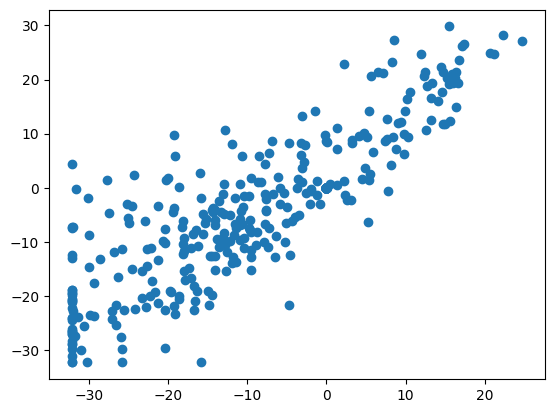

In [46]:
import matplotlib.pyplot as plt
spec_wavs2 = spec_wavs.detach().cpu().numpy()
plt.scatter(spec_wavs2[0][0],spec_wavs2[0][1])
plt.show()

(1025, 400)


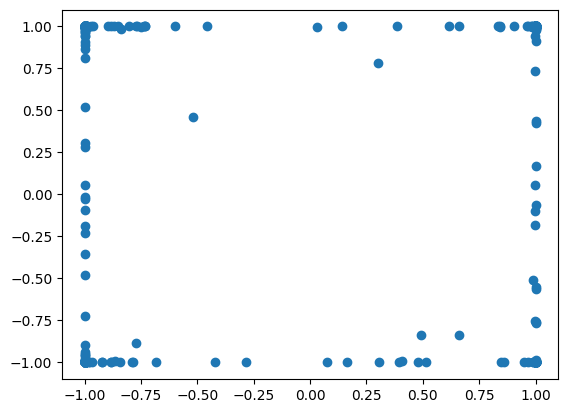

In [49]:
test2 = test.detach().cpu().numpy()
print(test2[0].shape)
plt.scatter(test2[0][0],test2[0][1])
plt.show()